In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import cv2
from PIL import Image
import os
import torch

/home/ubuntu/.local/lib/python3.7/site-packages/ipykernel_launcher.py:116: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use `.FigureManagerBase.set_window_title` or GUI-specific methods instead.


frame num: 2799


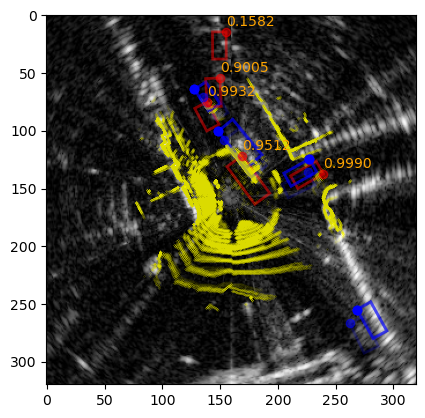

frame num: 2800


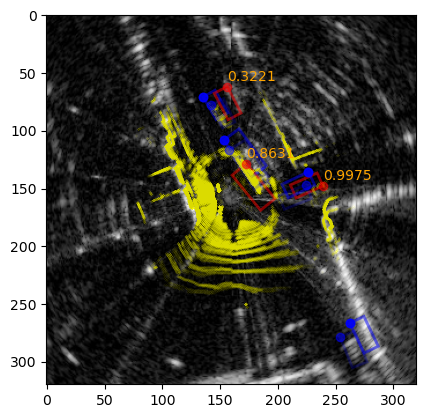

frame num: 2801


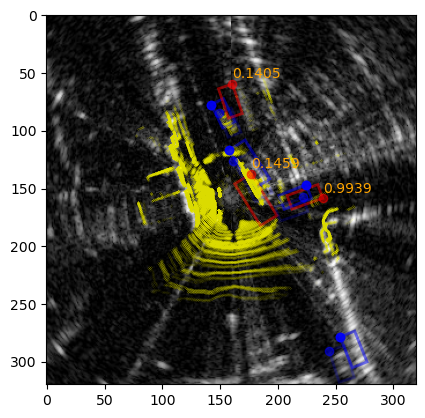

frame num: 2802


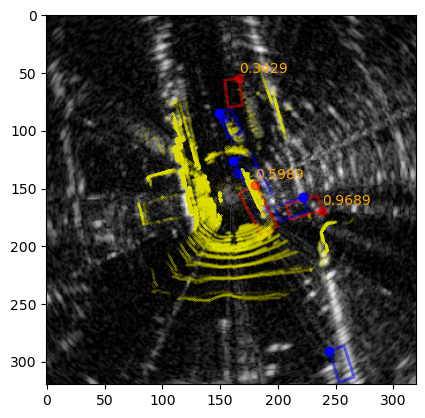

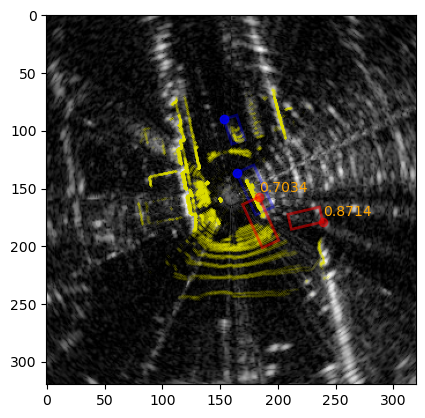

In [67]:
inputDataPath = '../data/RobotCar'

def readLidarData(filename): # 4 arrays [nx1]
    lidarData = np.fromfile(filename, dtype=np.float32)
    lidarData = np.reshape(lidarData,(-1,4))
    [pcNum,pcDim] = np.shape(lidarData)
    x_arr = []
    y_arr = []
    z_arr = []
    intensity_arr = []
    for i in range(pcNum):
        # coordinate transfer
        indx_x = 319-5 * (lidarData[i, 0]+32)
        indx_y = 5 * (lidarData[i, 1]+32)
        indx_z = 5*(lidarData[i,2])
        intensity = lidarData[i,3]
        if indx_x > 320 or indx_x < 0 or indx_y > 320 or indx_y < 0 or indx_z > 9:
            continue
        # pack them together
        x_arr.append(indx_x)
        y_arr.append(indx_y)
        z_arr.append(indx_z)
        intensity_arr.append(intensity)
    return x_arr, y_arr, z_arr, intensity_arr

def readRawIndex(): # dict {'2799' : '1547121487422169', '2800' : '__'}
    dict_temp = {}
    fn_evalIndex = os.path.join(inputDataPath,'ImageSets','eval.txt')
    file = open(fn_evalIndex)
    for line in file.readlines():
        line = line.strip()
        k = line.split(' ')[0]
        v = line.split(' ')[1]
        dict_temp[k] = v
    return dict_temp

# def readResult():
#     filename = './output/mvdnet/instances_predictions.csv'
#     return np.loadtxt(filename)
def readResult(filename = 'instances_predictions_cf.pth'):
    '''Array
    frameNumNow = resultMat[i, 0] -> 2799
    leftup_x = resultMat[i, 1]#+width/2
    leftup_y = resultMat[i, 2]#+height/2
    height = resultMat[i, 3]
    width = resultMat[i, 4]
    angle = resultMat[i, 5]
    red color for prediction
    '''
    checkpoint = torch.load(filename)
    len_eval = len(checkpoint)  # numper of evaluation set
    resultMat = []
    for i in range(len_eval):
        cars = checkpoint[i]['instances']
        frameNumNow = int(checkpoint[i]['image_id'])
        for j in range(len(cars)):
            leftup_x = cars[j]['bbox'][0]#+width/2
            leftup_y = cars[j]['bbox'][1]#+height/2
            height = cars[j]['bbox'][2]
            width = cars[j]['bbox'][3]
            angle = cars[j]['bbox'][4]
            score = cars[j]['score']
            resultArr = [frameNumNow, leftup_x, leftup_y, height, width, angle, score]
            resultMat.append(resultArr)
    resultMat = np.array(resultMat)
    return resultMat

def readLabel(labelFilename): # array: class car_id x y w h angle
    this_labelFilename = os.path.join(inputDataPath, 'object', 'label_2d', labelFilename)
    class_arr = []
    id_arr = []
    leftup_x_arr = []
    leftup_y_arr = []
    width_arr = []
    height_arr = []
    angle_arr = []
    with open(this_labelFilename, "r") as f:
        for line in f.readlines():
            tmp = line.split(' ')
            class_arr.append(tmp[0])
            id_arr.append(int(tmp[1]))
            # center-width/2+center_image
            # leftup_x = 5 * (float(tmp[2])-float(tmp[4])/2) + 319/2
            # leftup_y = 5 * (float(tmp[3])-float(tmp[5])/2) + 319/2
            leftup_x = 5 * (float(tmp[2])-float(tmp[5])/2) + 319/2
            leftup_y = 5 * (float(tmp[3])-float(tmp[5])/2) + 319/2
            # leftup_x = 5 * (float(tmp[2])) + 319/2
            # leftup_y = 5 * (float(tmp[3])) + 319/2
            leftup_x_arr.append(leftup_x)
            leftup_y_arr.append(leftup_y)
            width_arr.append(5 * float(tmp[4]))
            height_arr.append(5 * float(tmp[5]))
            # angle adjust
            angle = float(tmp[6])
            # if angle >= -112.5 and angle < 67.5:
            #   direction = 0
            # else:
            #   direction = 1
            # if angle < -112.5:
            #   angle = angle + 180
            # else:
            #   angle = angle - 180
            angle_arr.append(angle)
    return class_arr,id_arr,leftup_x_arr,leftup_y_arr,width_arr,height_arr,angle_arr

def drawOutput(resultMat, rawIndexDict):
    [objNUm, resDim] = np.shape(resultMat)
    frameNum = 2799
    # print(set(resultMat[:,0]))
    fig = plt.figure()
    for i in range(objNUm):
        frameNumNow = int(resultMat[i, 0]) # 2799
        if frameNumNow == 2804: # exit loop condition
            break 
        timestamp = rawIndexDict[str(frameNumNow)] # '2799' -> '1547121487422169', (.bin?)
        fig.canvas.set_window_title(str(timestamp))
        # read raw data images
        if frameNumNow != frameNum:
            print("frame num: {}".format(frameNum))
        # read lidar data
        lidarFilename = '{}.bin'.format(timestamp) # '1547121487422169.bin'
        lidar_rawDataFilename = os.path.join(inputDataPath, 'object', 'lidar',lidarFilename) # no fog
        # lidar_rawDataFilename = os.path.join(inputDataPath, 'object', 'lidar',lidarFilename) # fog 0.06
        [x_arr, y_arr, z_arr, intensity_arr] = readLidarData(lidar_rawDataFilename) # lidar value
        # read radar data
        radarFilename = '{}.jpg'.format(timestamp) # '1547121487422169.png'
        radar_rawDataFilename = os.path.join(inputDataPath, 'object','radar',radarFilename)
        # draw point cloud and radar image

        plt.imshow(Image.open(radar_rawDataFilename), cmap='gray') # radar image
        plt.scatter(y_arr, x_arr,s=0.01,c='yellow', alpha=0.2)
        # load label bbox
        # read label 2d
        labelFilename = '{}.txt'.format(timestamp)
        [class_arr, id, label_leftup_x, label_leftup_y, label_width, label_height, label_angle] = readLabel(labelFilename) # true labels
        # for j in range(len(id)):  # cars in the figure
        for j in range(len(id)):  # cars in the figure
            plt.gca().add_patch(patches.Rectangle((label_leftup_x[j], label_leftup_y[j]), label_width[j], label_height[j],
                                                  # angle = 180angle/np.pi,
                                                    angle=180-label_angle[j],
                                                    edgecolor='blue',
                                                    facecolor='none',
                                                    lw=2,
                                                    alpha=0.2))
            plt.plot(label_leftup_x[j], label_leftup_y[j],'bo', alpha=0.5)
        # load result bbox
        height = resultMat[i, 3]
        width = resultMat[i, 4]
        leftup_x = resultMat[i, 1]#+width/2
        leftup_y = resultMat[i, 2]#+height/2
        angle = resultMat[i, 5]
        s = '{:.4f}'.format(resultMat[i, 6])
        # draw them together
        if frameNumNow == frameNum:
            plt.gca().add_patch(patches.Rectangle((leftup_x,leftup_y),width,height,
                                                    # angle = 180angle/np.pi,
                                                    angle = 90-angle,
                                                    edgecolor='red',
                                                    facecolor='none',
                                                    lw=2,
                                                    alpha=0.5))
            plt.plot(leftup_x,leftup_y,'ro', alpha=0.5)
            plt.text(leftup_x, leftup_y-5, s, color='orange')
            # pass
        else:
            # plt.hold(False)
            plt.pause(0.1)
            if frameNumNow == 2830:
                plt.pause(0)
            plt.clf()
            frameNum = frameNumNow
            
def main():
    resultMat = readResult()
    rawDataIndexDict = readRawIndex()
    drawOutput(resultMat, rawDataIndexDict)
    pass

main()

In [61]:
def drawOutput(resultMat, rawIndexDict):
    [objNUm, resDim] = np.shape(resultMat)
    print([objNUm, resDim])
    # print(resultMat[:10,0])
    print(len(list(set(resultMat[:,0]))))
    # frameNum = 2799
    # print(set(resultMat[:,0]))
    # fig = plt.figure()
    # for i in range(objNUm):
    #     frameNumNow = int(resultMat[i, 0]) # 2799
    #     if frameNumNow == 2804: # exit loop condition
    #         break 
    #     timestamp = rawIndexDict[str(frameNumNow)] # '2799' -> '1547121487422169', (.bin?)
    #     fig.canvas.set_window_title(str(timestamp))
    #     # read raw data images
    #     if frameNumNow != frameNum:
    #         print("frame num: {}".format(frameNum))
    #     # read lidar data
    #     lidarFilename = '{}.bin'.format(timestamp) # '1547121487422169.bin'
    #     lidar_rawDataFilename = os.path.join(inputDataPath, 'object', 'lidar',lidarFilename) # no fog
    #     # lidar_rawDataFilename = os.path.join(inputDataPath, 'object', 'lidar',lidarFilename) # fog 0.06
    #     [x_arr, y_arr, z_arr, intensity_arr] = readLidarData(lidar_rawDataFilename) # lidar value
    #     # read radar data
    #     radarFilename = '{}.jpg'.format(timestamp) # '1547121487422169.png'
    #     radar_rawDataFilename = os.path.join(inputDataPath, 'object','radar',radarFilename)
    #     # draw point cloud and radar image

    #     plt.imshow(Image.open(radar_rawDataFilename), cmap='gray') # radar image
    #     plt.scatter(y_arr, x_arr,s=0.01,c='yellow', alpha=0.2)
    #     # load label bbox
    #     # read label 2d
    #     labelFilename = '{}.txt'.format(timestamp)
    #     [class_arr, id, label_leftup_x, label_leftup_y, label_width, label_height, label_angle] = readLabel(labelFilename) # true labels
    #     # for j in range(len(id)):  # cars in the figure
    #     # for j in range(len(id)):  # cars in the figure
    #     #     plt.gca().add_patch(patches.Rectangle((label_leftup_x[j], label_leftup_y[j]), label_width[j], label_height[j],
    #     #                                           # angle = 180angle/np.pi,
    #     #                                             angle=180-label_angle[j],
    #     #                                             edgecolor='blue',
    #     #                                             facecolor='none',
    #     #                                             lw=2,
    #     #                                             alpha=0.2))
    #         # plt.plot(label_leftup_x[j], label_leftup_y[j],'bo', alpha=0.5)
    #     # load result bbox
    #     height = resultMat[i, 3]
    #     width = resultMat[i, 4]
    #     leftup_x = resultMat[i, 1]#+width/2
    #     leftup_y = resultMat[i, 2]#+height/2
    #     angle = resultMat[i, 5]
    #     s = '{:.4f}'.format(resultMat[i, 6])
    #     # draw them together
    #     if frameNumNow == frameNum:
    #         plt.gca().add_patch(patches.Rectangle((leftup_x,leftup_y),width,height,
    #                                                 # angle = 180angle/np.pi,
    #                                                 angle = 90-angle,
    #                                                 edgecolor='red',
    #                                                 facecolor='none',
    #                                                 lw=2,
    #                                                 alpha=0.5))
    #         plt.plot(leftup_x,leftup_y,'bo', alpha=0.5)
    #         plt.text(leftup_x, leftup_y-5, s, color='orange')
    #         # pass
    #     else:
    #         # plt.hold(False)
    #         plt.pause(0.1)
    #         if frameNumNow == 2830:
    #             plt.pause(0)
    #         plt.clf()
    #         frameNum = frameNumNow
    
resultMat = readResult()
rawDataIndexDict = readRawIndex()
drawOutput(resultMat, rawDataIndexDict)


[15946, 7]
1780


In [63]:
len(rawDataIndexDict)

1790